## Before started
Building 2 Convolution Neural Networks and some techniques in evaluation, optimization, regularization based on "ImageNet Classification with Deep Convolutional Neural Networks" which that introduced AlexNet model

Using pytorch for training with GPU to have fastly and correctly our goals

## PART 1: SET UP AND DEFINE MODEL ARCHITECTURE

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- CONFIGURATION ---
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 15  # Increased to 15 to clearly see convergence
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

class CustomAlexNetCIFAR(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomAlexNetCIFAR, self).__init__()

        # --- PART 1: FEATURE EXTRACTOR ---
        # Block 1: Conv(32, 5x5, s=1, p=2) -> ReLU -> MaxPool(2x2, s=2)
        # Input: 32x32 -> Conv: 32x32 -> Pool: 16x16
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Block 2: Conv(64, 5x5, s=1, p=2) -> ReLU -> MaxPool(2x2, s=2)
        # Input: 16x16 -> Conv: 16x16 -> Pool: 8x8
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Block 3: Conv(96, 3x3, s=1, p=1) -> ReLU
        # Input: 8x8 -> Output: 8x8
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        # Block 4: Conv(96, 3x3, s=1, p=1) -> ReLU
        # Input: 8x8 -> Output: 8x8
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        # Block 5: Conv(64, 3x3, s=1, p=1) -> ReLU -> MaxPool(2x2, s=2)
        # Input: 8x8 -> Conv: 8x8 -> Pool: 4x4
        self.block5 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # --- PART 3: CLASSIFIER ---
        # Flatten size = 64 filters * 4 * 4 = 1024 features
        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
            # Softmax is integrated into nn.CrossEntropyLoss during training
        )

    def forward(self, x):
        # Feature Extractor
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)

        # --- PART 2: RESIZE (Flatten) ---
        x = torch.flatten(x, 1)

        # Classifier
        x = self.classifier(x)
        return x

Using device: cuda


## PART 2: DATA PREPARATION


In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize to [-1, 1]
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

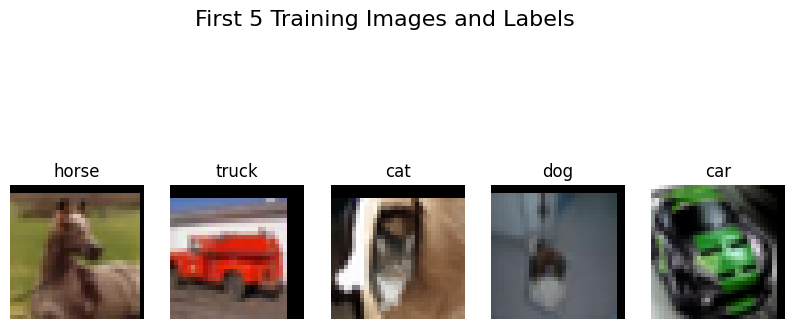

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img, title=None):
    img = img / 2 + 0.5  # denormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')

# Get 5 random training images and their labels
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Create a figure to display the images
plt.figure(figsize=(10, 5))

# Display 5 images
for i in range(5):
    plt.subplot(1, 5, i+1)
    imshow(images[i])
    plt.title(classes[labels[i]])
plt.suptitle('First 5 Training Images and Labels', fontsize=16)
plt.show()

## PART 3: TRAINING LOOP (Common architecture)

In [15]:
model_1 = CustomAlexNetCIFAR().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=LEARNING_RATE)

train_losses = []

for epoch in range(EPOCHS):
    running_loss = 0.0
    model_1.train() # Set to training mode

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

        optimizer.zero_grad()         # Reset gradient
        outputs = model_1(inputs)       # Forward
        loss = criterion(outputs, labels) # Calculate loss
        loss.backward()               # Backward
        optimizer.step()              # Update weights

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)
    print(f'[Epoch {epoch + 1}/{EPOCHS}] Loss: {avg_loss:.4f}')


[Epoch 1/15] Loss: 1.5708
[Epoch 2/15] Loss: 1.1357
[Epoch 3/15] Loss: 0.9230
[Epoch 4/15] Loss: 0.7791
[Epoch 5/15] Loss: 0.6813
[Epoch 6/15] Loss: 0.5969
[Epoch 7/15] Loss: 0.5130
[Epoch 8/15] Loss: 0.4517
[Epoch 9/15] Loss: 0.3933
[Epoch 10/15] Loss: 0.3408
[Epoch 11/15] Loss: 0.2911
[Epoch 12/15] Loss: 0.2618
[Epoch 13/15] Loss: 0.2286
[Epoch 14/15] Loss: 0.2098
[Epoch 15/15] Loss: 0.1886


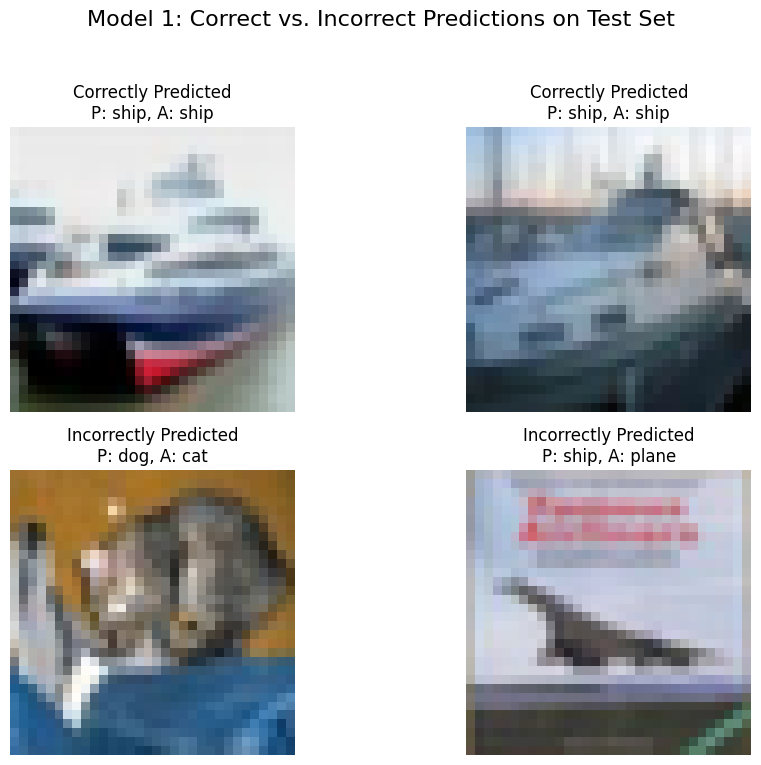

In [16]:
# Get correctly predicted and incorrectly predicted images by model_1 on the test set
model_1.eval() # Set model_1 to evaluation mode

correct_predictions = []
incorrect_predictions = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(DEVICE), data[1].to(DEVICE)
        outputs = model_1(images)
        _, predicted = torch.max(outputs.data, 1)

        for i in range(len(labels)):
            if predicted[i] == labels[i]:
                if len(correct_predictions) < 2:
                    correct_predictions.append((images[i].cpu(), labels[i].item(), predicted[i].item()))
            else:
                if len(incorrect_predictions) < 2:
                    incorrect_predictions.append((images[i].cpu(), labels[i].item(), predicted[i].item()))

            if len(correct_predictions) == 2 and len(incorrect_predictions) == 2:
                break
        if len(correct_predictions) == 2 and len(incorrect_predictions) == 2:
            break

plt.figure(figsize=(10, 8))

# Display correctly predicted images
for i, (img, true_label, pred_label) in enumerate(correct_predictions):
    plt.subplot(2, 2, i + 1)
    imshow(img)
    plt.title(f'Correctly Predicted\nP: {classes[pred_label]}, A: {classes[true_label]}')

# Display incorrectly predicted images
for i, (img, true_label, pred_label) in enumerate(incorrect_predictions):
    plt.subplot(2, 2, i + 3)
    imshow(img)
    plt.title(f'Incorrectly Predicted\nP: {classes[pred_label]}, A: {classes[true_label]}')

plt.suptitle('Model 1: Correct vs. Incorrect Predictions on Test Set', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## PART 4: EVALUATE & VISUALIZE FOR NO REGURLARIZATION MODEL

Training Accuracy: 95.34 %
Test Accuracy:     74.07 %
Gap:               21.27 %


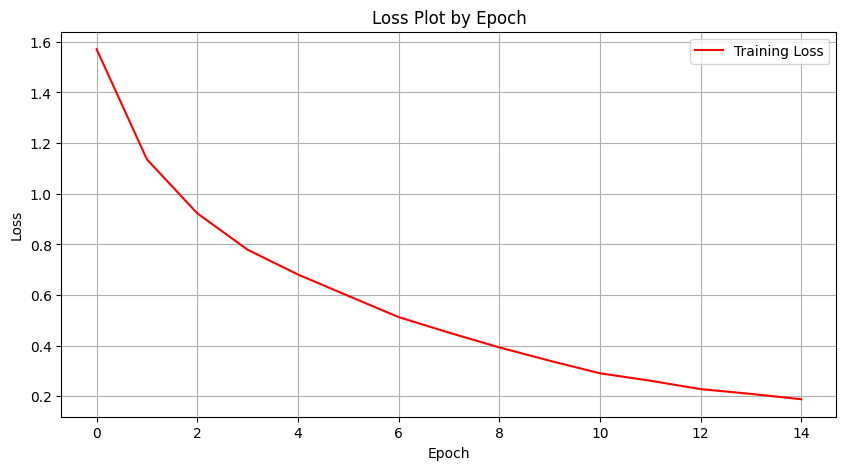

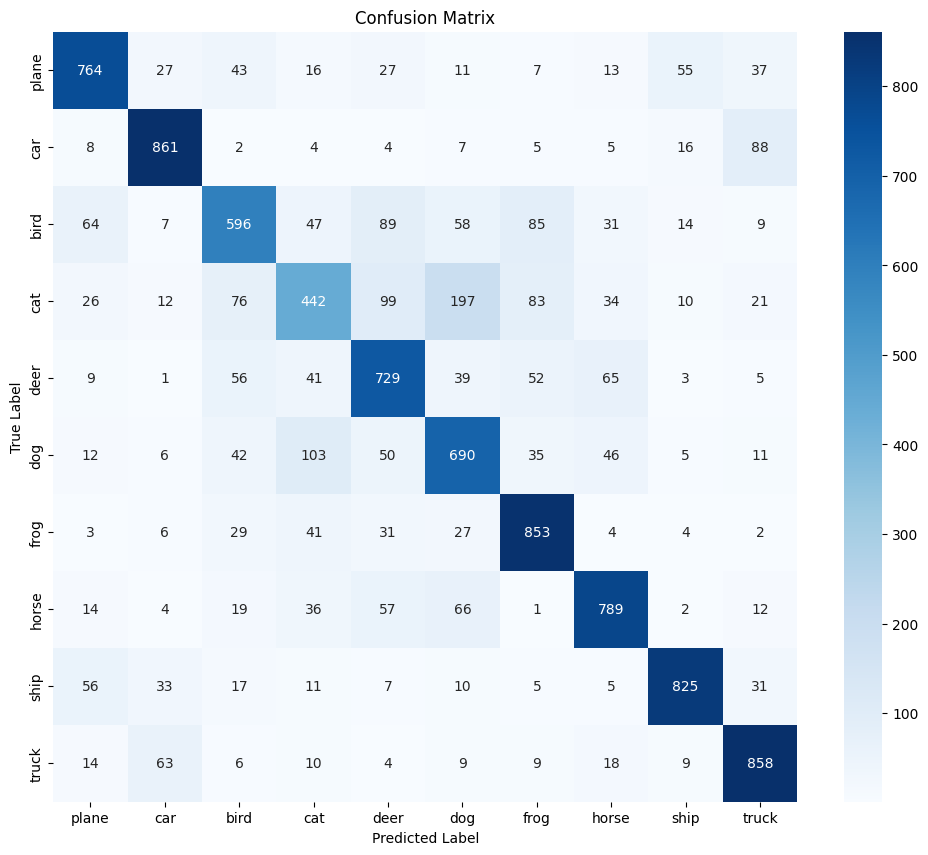

              precision    recall  f1-score   support

       plane       0.79      0.76      0.78      1000
         car       0.84      0.86      0.85      1000
        bird       0.67      0.60      0.63      1000
         cat       0.59      0.44      0.50      1000
        deer       0.66      0.73      0.70      1000
         dog       0.62      0.69      0.65      1000
        frog       0.75      0.85      0.80      1000
       horse       0.78      0.79      0.79      1000
        ship       0.87      0.82      0.85      1000
       truck       0.80      0.86      0.83      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



In [17]:
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(DEVICE), data[1].to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    return accuracy, all_labels, all_preds

# Training accuracy
train_accuracy, _, _ = evaluate_model(model_1, trainloader)

# Test accuracy
test_accuracy, y_true, y_pred = evaluate_model(model_1, testloader)

print(f'Training Accuracy: {train_accuracy:.2f} %')
print(f'Test Accuracy:     {test_accuracy:.2f} %')
print(f'Gap:               {train_accuracy - test_accuracy:.2f} %')

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='red')
plt.title('Loss Plot by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Detailed Report
print(classification_report(y_true, y_pred, target_names=classes))

## PART 5: REGULARIZATION DATA AUGMENTATION & DROP OUT

In [3]:
# Define transform
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontal 50%
    transforms.RandomCrop(32, padding=4),    # Crop random
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Transform for test, no augmentation for test just transform for training set
standard_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# DEFINING CHILD MODEL
class CustomAlexNetCIFAR_Dropout(CustomAlexNetCIFAR):
    def __init__(self, num_classes=10):
        # init parent (block1 -> block5)
        super(CustomAlexNetCIFAR_Dropout, self).__init__(num_classes)

        # Linear to fit drop out

        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # class parent
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        # resize
        x = torch.flatten(x, 1)
        # classifier
        # Layer FC1 -> ReLU -> Dropout
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Layer FC2 -> ReLU -> Dropout
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Layer FC3 (Output)
        x = self.fc3(x)

        return x

Data BEFORE Augmentation:


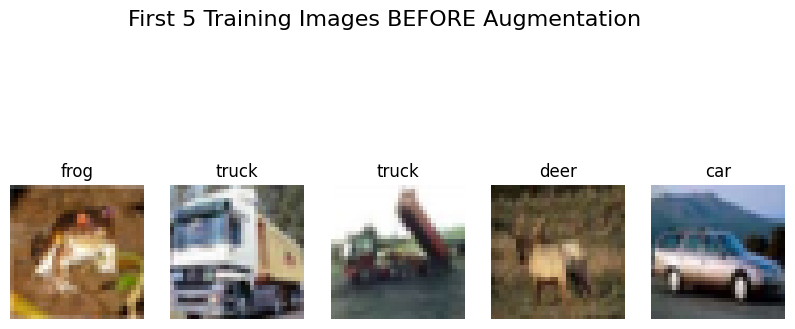


Data AFTER Augmentation:


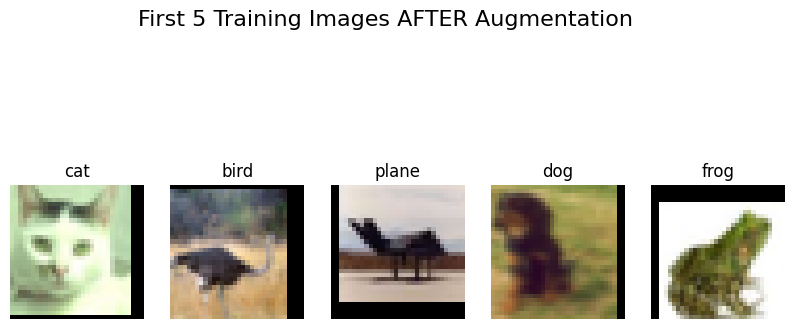

In [13]:
# --- Display data BEFORE augmentation ---
print("Data BEFORE Augmentation:")
# Re-create trainset/loader with original transform for visualization
original_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize to [-1, 1]
])
original_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=False, transform=original_transform) # download=False as it's already downloaded
original_trainloader = torch.utils.data.DataLoader(original_trainset, batch_size=BATCH_SIZE,
                                                  shuffle=False, num_workers=2) # shuffle=False for consistent examples

dataiter_orig = iter(original_trainloader)
images_orig, labels_orig = next(dataiter_orig)

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    imshow(images_orig[i].cpu()) # Ensure images are on CPU for numpy conversion
    plt.title(classes[labels_orig[i]])
plt.suptitle('First 5 Training Images BEFORE Augmentation', fontsize=16)
plt.show()

# --- Display data AFTER augmentation ---
print("\nData AFTER Augmentation:")
# The current 'trainloader' uses 'augmentation_transform'
dataiter_aug = iter(trainloader) # Use the existing augmented trainloader
images_aug, labels_aug = next(dataiter_aug)

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    imshow(images_aug[i].cpu()) # Ensure images are on CPU for numpy conversion
    plt.title(classes[labels_aug[i]])
plt.suptitle('First 5 Training Images AFTER Augmentation', fontsize=16)
plt.show()

#### LOAD DATA


In [4]:
# Train set uses augmentation_transform
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=augmentation_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# Test set uses standard_transform
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=standard_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

## PART 6: TRAINING PROCESS

In [ ]:
model_2 = CustomAlexNetCIFAR_Dropout().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=LEARNING_RATE)

train_losses = []

for epoch in range(EPOCHS):
    model_2.train() # Enable Dropout
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

        optimizer.zero_grad()
        outputs = model_2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)
    print(f'[Epoch {epoch + 1}/{EPOCHS}] Loss: {avg_loss:.4f}')

[Epoch 1/15] Loss: 1.8260
[Epoch 2/15] Loss: 1.4201
[Epoch 3/15] Loss: 1.2424
[Epoch 4/15] Loss: 1.1173
[Epoch 5/15] Loss: 1.0428
[Epoch 6/15] Loss: 0.9712
[Epoch 7/15] Loss: 0.9208
[Epoch 8/15] Loss: 0.8871
[Epoch 9/15] Loss: 0.8564
[Epoch 10/15] Loss: 0.8304
[Epoch 11/15] Loss: 0.8040
[Epoch 12/15] Loss: 0.7851
[Epoch 13/15] Loss: 0.7691
[Epoch 14/15] Loss: 0.7587
[Epoch 15/15] Loss: 0.7448


## PART 7: EVALUATION (Accuracy, Matrix, Report)

Training Accuracy: 77.10 %
Test Accuracy:     75.60 %
Gap:               1.50 %


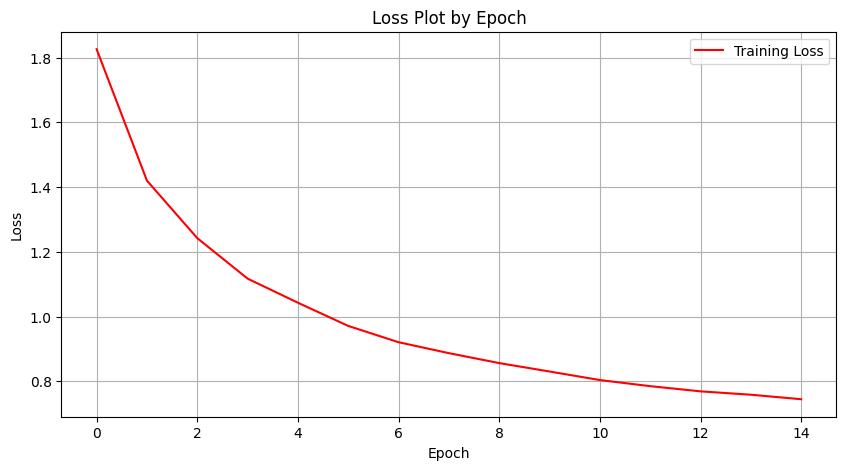

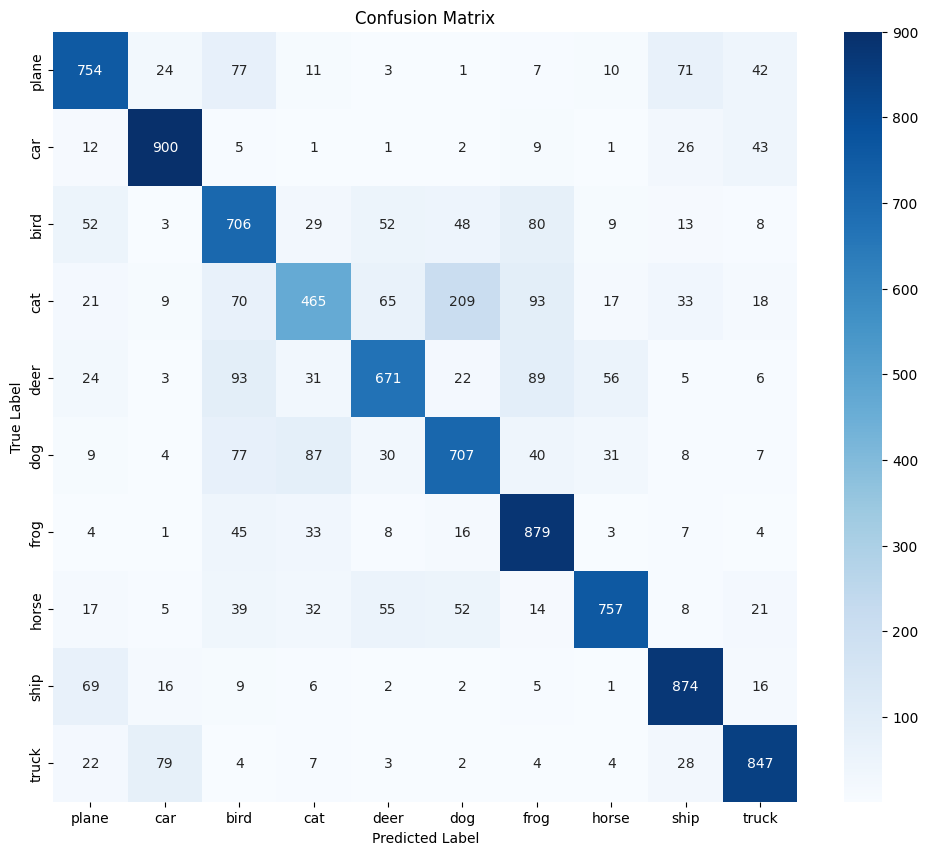

              precision    recall  f1-score   support

       plane       0.77      0.75      0.76      1000
         car       0.86      0.90      0.88      1000
        bird       0.63      0.71      0.66      1000
         cat       0.66      0.47      0.55      1000
        deer       0.75      0.67      0.71      1000
         dog       0.67      0.71      0.69      1000
        frog       0.72      0.88      0.79      1000
       horse       0.85      0.76      0.80      1000
        ship       0.81      0.87      0.84      1000
       truck       0.84      0.85      0.84      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.75     10000
weighted avg       0.76      0.76      0.75     10000



In [ ]:
# Training accuracy
train_accuracy, _, _ = evaluate_model(model_2, trainloader)

# Test accuracy
test_accuracy, y_true, y_pred = evaluate_model(model_2, testloader)

print(f'Training Accuracy: {train_accuracy:.2f} %')
print(f'Test Accuracy:     {test_accuracy:.2f} %')
print(f'Gap:               {train_accuracy - test_accuracy:.2f} %')

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='red')
plt.title('Loss Plot by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Detailed Report
print(classification_report(y_true, y_pred, target_names=classes))

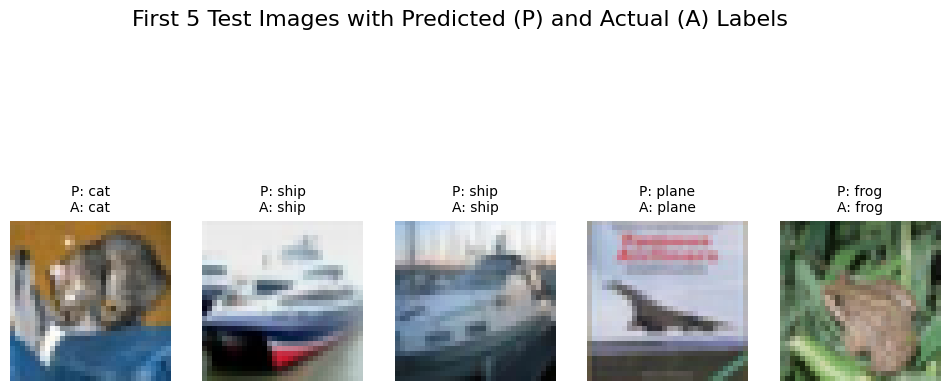

In [12]:
# Get 5 random test images, their true labels, and model predictions
model_2.eval() # Set model to evaluation mode
dataiter = iter(testloader)
images, labels = next(dataiter)

# Get predictions from the model
outputs = model_2(images.to(DEVICE))
_, predicted = torch.max(outputs.data, 1)

# Create a figure to display the images
plt.figure(figsize=(12, 6))

# Display 5 images with predicted and actual labels
for i in range(5):
    plt.subplot(1, 5, i+1)
    imshow(images[i].cpu())
    plt.title(f'P: {classes[predicted[i]]}\nA: {classes[labels[i]]}', fontsize=10)
plt.suptitle('First 5 Test Images with Predicted (P) and Actual (A) Labels', fontsize=16)
plt.show()

## PART 8: HYPERPARAMETERS OPTIMIZATION (Grid Search)

In [5]:
search_lrs = [0.00075, 0.0005]
search_batch_sizes = [48, 64]
drop_out = [0.4, 0.5, 0.6]
SEARCH_EPOCHS = 20

best_accuracy = 0.0
best_params = {}

case_count = 0


for do in drop_out:
    for lr in search_lrs:
        for bs in search_batch_sizes:
            case_count += 1
            print(f"\n[Case {case_count}] Testing: Dropout={do} | LR={lr} | Batch Size={bs}")

            current_trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=2)
            current_testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=2)

            model_search = CustomAlexNetCIFAR_Dropout(num_classes=10).to(DEVICE)
            model_search.dropout = nn.Dropout(p=do)

            optimizer = optim.Adam(model_search.parameters(), lr=lr)
            criterion = nn.CrossEntropyLoss()

            for epoch in range(SEARCH_EPOCHS):
                model_search.train()
                running_loss = 0.0

                for inputs, labels in current_trainloader:
                    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

                    optimizer.zero_grad()
                    outputs = model_search(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()

                if epoch == SEARCH_EPOCHS - 1:
                    print(f"   -> Epoch {epoch+1} Loss: {running_loss / len(current_trainloader):.4f}")

            model_search.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in current_testloader:
                    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                    outputs = model_search(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            current_acc = 100 * correct / total
            print(f"   -> Accuracy: {current_acc:.2f}%")

            if current_acc > best_accuracy:
                best_accuracy = current_acc
                best_params = {'lr': lr, 'batch_size': bs, 'dropout': do}

print(f"Best Parameters:")
print(f"- Dropout Rate:  {best_params['dropout']}")
print(f"- Learning Rate: {best_params['lr']}")
print(f"- Batch Size:    {best_params['batch_size']}")
print(f"- Accuracy:      {best_accuracy:.2f}%")


[Case 1] Testing: Dropout=0.4 | LR=0.00075 | Batch Size=48
   -> Epoch 20 Loss: 0.6702
   -> Accuracy: 77.42%

[Case 2] Testing: Dropout=0.4 | LR=0.00075 | Batch Size=64
   -> Epoch 20 Loss: 0.5769
   -> Accuracy: 80.48%

[Case 3] Testing: Dropout=0.4 | LR=0.0005 | Batch Size=48
   -> Epoch 20 Loss: 0.5463
   -> Accuracy: 80.66%

[Case 4] Testing: Dropout=0.4 | LR=0.0005 | Batch Size=64
   -> Epoch 20 Loss: 0.5368
   -> Accuracy: 80.26%

[Case 5] Testing: Dropout=0.5 | LR=0.00075 | Batch Size=48
   -> Epoch 20 Loss: 0.6746
   -> Accuracy: 77.78%

[Case 6] Testing: Dropout=0.5 | LR=0.00075 | Batch Size=64
   -> Epoch 20 Loss: 0.5959
   -> Accuracy: 78.25%

[Case 7] Testing: Dropout=0.5 | LR=0.0005 | Batch Size=48
   -> Epoch 20 Loss: 0.5536
   -> Accuracy: 79.45%

[Case 8] Testing: Dropout=0.5 | LR=0.0005 | Batch Size=64
   -> Epoch 20 Loss: 0.5860
   -> Accuracy: 78.85%

[Case 9] Testing: Dropout=0.6 | LR=0.00075 | Batch Size=48
   -> Epoch 20 Loss: 0.7807
   -> Accuracy: 74.89%

[Cas